### Loading libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
import random
from tqdm.notebook import tqdm
from PIL import Image
from PIL import ImageEnhance
pd.set_option('display.max_colwidth', None)

### Segmentation

Defining Paths

In [2]:
def get_img(path_str):
    # reads at RGB
    return np.asarray(Image.open(path_str))

def show_img(img):
    plt.imshow(img)
    plt.show()

def show_img_gray(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.show()

def get_gray(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def apply_threshold(img):
    return cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

def get_edge(img):
    return cv2.dilate(cv2.Canny(img, 0, 255), None)

def get_mask(edge_img):
    cnt = sorted(cv2.findContours(edge_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask_shape = edge_img.shape[0],edge_img.shape[1]
    mask = np.zeros(mask_shape, np.uint8)
    return cv2.drawContours(mask, [cnt],-1, 255, -1)




In [3]:
def edge_based_segmentation(img, show_image = True):
    edge_img = get_edge(apply_threshold(get_gray(img)))
    mask_img = get_mask(edge_img)
    if show_image : 
        show_img(img)
        show_img_gray(mask_img)
    return mask_img

In [4]:
# todo make it read image as binary
def read_true_mask(img_path_str):
    img = Image.open(img_path_str)
    return cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2GRAY)

In [5]:
def print_IOU(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    union = 0
    intersection = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 or seg_mask_img[i][j]!=0 :
                union+=1
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                intersection += 1
    
    iou = intersection/union

    print("IOU for image is ", iou)


In [6]:
def print_pixel_accuracy(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    correct_pixel = 0
    total_pixel = h*w

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                correct_pixel += 1
            if org_mask_img[i][j]==0 and seg_mask_img[i][j]==0:
                correct_pixel += 1
    
    accuracy = correct_pixel / total_pixel

    print("Pixel Accuracy for image  is ", accuracy)

In [7]:
def print_f1_score(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    overlap = 0

    pixel_1 = 0
    pixel_2 = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0 :
                overlap+=1
            if org_mask_img[i][j]!=0 :
                pixel_1 += 1
            if seg_mask_img[i][j]!=0:
                pixel_2 += 1
    
    f1 = 2*(overlap)/(pixel_2 + pixel_1)

    print("F1 score for image is ", f1)

In [17]:
def find_metrics(seg_mask_img, org_mask_img):
    f1, iou, pixacc = 0,0,0 
    intersection = np.sum( np.logical_and(seg_mask_img, org_mask_img) )
    union = np.sum ( np.logical_or(seg_mask_img, org_mask_img) )
    cnt_seg = np.count_nonzero(seg_mask_img)
    cnt_org = np.count_nonzero(org_mask_img)
    h,w = seg_mask_img.shape
    cnt_tot = h*w 
    cnt_true = intersection
    cnt_false = cnt_tot - union 

    f1 = 2 * intersection / (cnt_seg + cnt_org) 
    iou = intersection / union
    pixacc = (cnt_true + cnt_false) / cnt_tot

    return f1, iou, pixacc

def print_all(seg_mask_img, org_mask_img):
    f1, iou, pixacc = find_metrics(seg_mask_img, org_mask_img)
    print("f1 = ", f1, " iou = ", iou, " pixacc = ", pixacc)


    

In [8]:
path = "./Images"
img_paths = glob.glob(os.path.join(path,"*.JPG"))
img_paths

['./Images/img3.JPG',
 './Images/img2.JPG',
 './Images/img1.JPG',
 './Images/img0.JPG']

In [9]:
base_path = '../Dataset_generation/final_dataset/'
mask_paths = glob.glob(os.path.join('./Masks', "*.JPG"))
mask_paths

num_images = len(mask_paths)

In [22]:
img = get_img(img_paths[1])

seg_mask_img = edge_based_segmentation(img, show_image=False)
org_mask_img = read_true_mask(mask_paths[1])
#show_img_gray(org_mask_img)

In [23]:
print_all(seg_mask_img, org_mask_img)

f1 =  0.41416217662584076  iou =  0.26116300829843697  pixacc =  0.7107087087087087


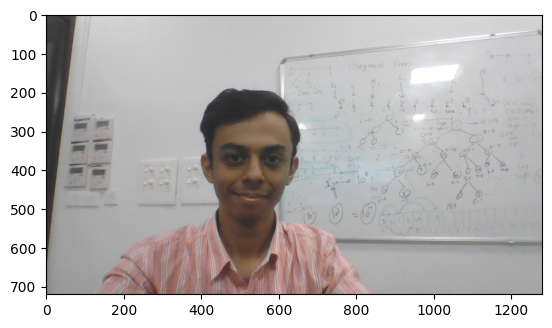

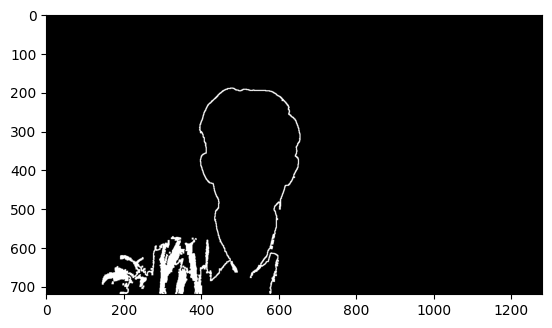

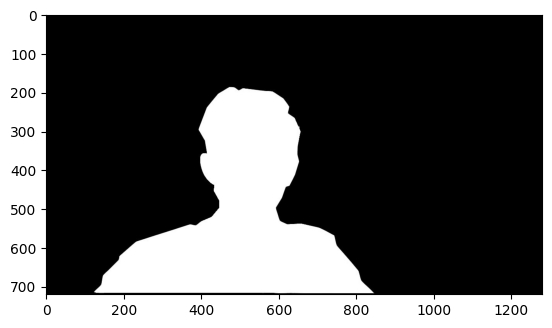

IOU for image is  0.1037021000216497
Pixel Accuracy for image  is  0.8248046875
F1 score for image is  0.18791683012946253
f1 =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]  iou =  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]  pixacc =  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


/tmp/ipykernel_50071/1731735657.py:13: RuntimeWarning: invalid value encountered in divide
  iou = intersection / union


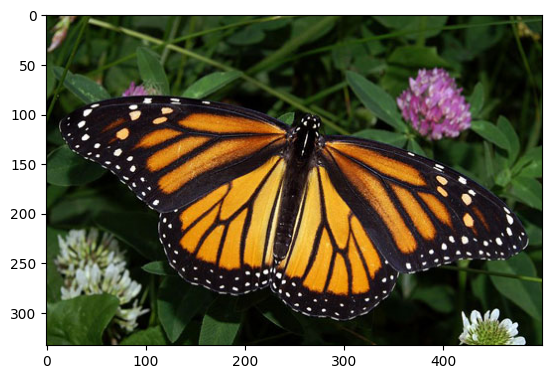

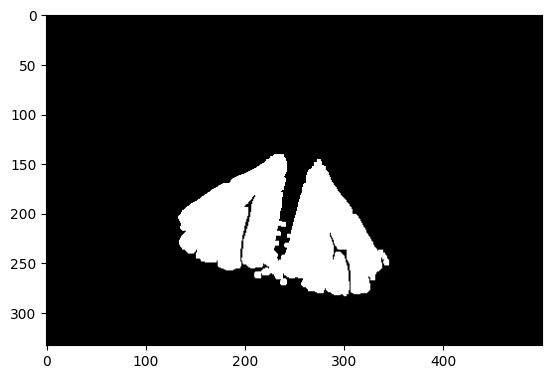

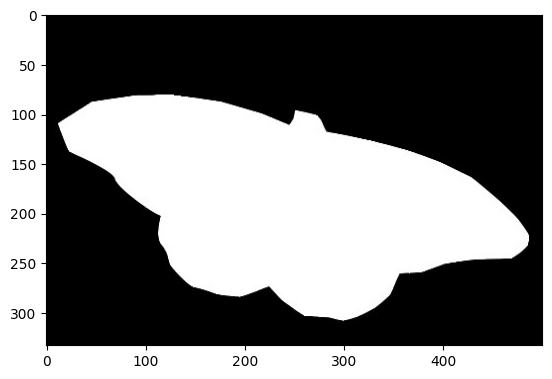

IOU for image is  0.26116300829843697
Pixel Accuracy for image  is  0.7107087087087087
F1 score for image is  0.41416217662584076
f1 =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]  iou =  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]  pixacc =  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


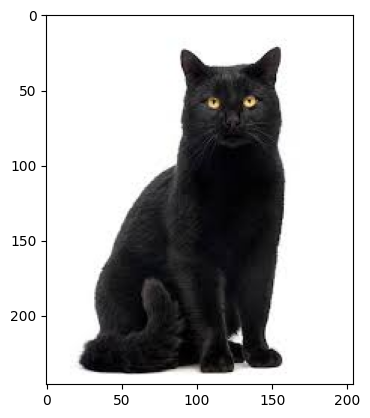

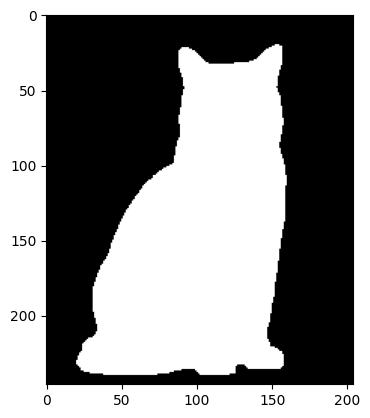

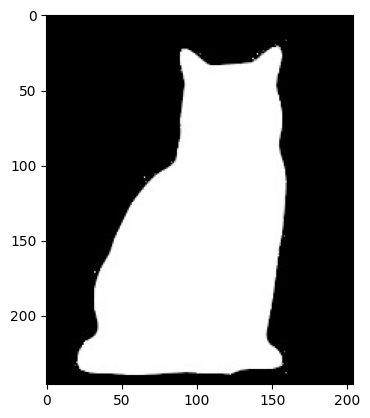

IOU for image is  0.9497321220591661
Pixel Accuracy for image  is  0.9784991232265264
F1 score for image is  0.9742180593056319
f1 =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]  iou =  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]  pixacc =  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


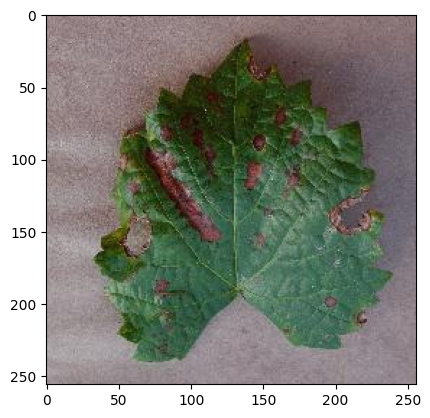

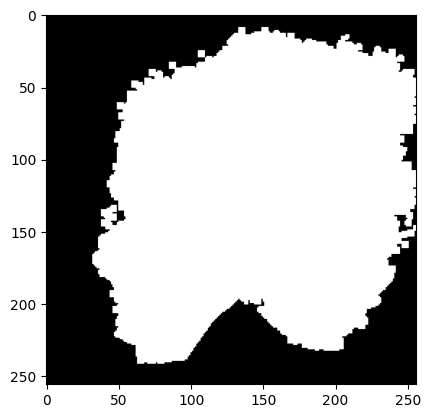

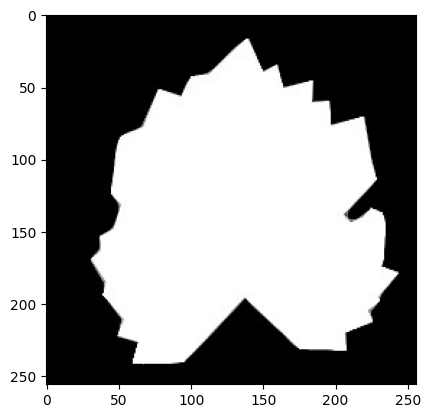

IOU for image is  0.7786103542234333
Pixel Accuracy for image  is  0.86114501953125
F1 score for image is  0.875526618153964
f1 =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]  iou =  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]  pixacc =  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [12]:
for i in range(0, num_images):

    img = get_img(img_paths[i])

    seg_mask_img = edge_based_segmentation(img)
    org_mask_img = read_true_mask(mask_paths[i])
    show_img_gray(org_mask_img)

    print_IOU(seg_mask_img, org_mask_img)
    print_pixel_accuracy(seg_mask_img, org_mask_img)
    print_f1_score(seg_mask_img, org_mask_img)

    print_all(seg_mask_img, org_mask_img)
